# Recommendation Engine - Anime Recommendations

### Aim of the Assignment
The raport looks into Anime Film dataset and provides top-10 recommendations for customers based on their previous reviews. 

### About the Dataset
Source: [Kaggle](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database) \
The dataset of two csv files contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.


## 1. Load and Transform the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from surprise import Reader
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

In [2]:
ratings_df = pd.read_csv('rating.csv')
#as the dataset is large, select only first 1000 columns
ratings_df =ratings_df.head(5000)

In [3]:
ratings_df.shape

(5000, 3)

In [4]:
ratings_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
4995,51,849,8
4996,51,853,8
4997,51,877,10
4998,51,889,9


In [5]:
#notice the data has a lot of -1 values (movie watched but not rated)
#as unnecessary, remove them
ratings_df.drop(ratings_df.loc[ratings_df['rating']==-1].index, inplace=True)
ratings_df.shape

(3927, 3)

In [6]:
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [7]:
anime_df.shape

(12294, 7)

In [8]:
#check the number of missing values
nan_count = ratings_df.isna().sum()
nan_count

user_id     0
anime_id    0
rating      0
dtype: int64

In [9]:
nan_count = anime_df.isna().sum()
nan_count

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [10]:
#check the number of duplicates
dups_count = anime_df.duplicated()
dups_count.sum()

0

In [11]:
dups_count = ratings_df.duplicated()
dups_count.sum()

0

In [12]:
df = ratings_df.merge(anime_df, left_on='anime_id', right_on='anime_id', how='left')
df

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315
...,...,...,...,...,...,...,...,...,...
3922,51,849,8,Suzumiya Haruhi no Yuuutsu,"Comedy, Mystery, Parody, School, Sci-Fi, Slice...",TV,14,8.06,428569
3923,51,853,8,Ouran Koukou Host Club,"Comedy, Harem, Romance, School, Shoujo",TV,26,8.39,422271
3924,51,877,10,Nana,"Comedy, Drama, Music, Romance, Shoujo, Slice o...",TV,47,8.55,197256
3925,51,889,9,Black Lagoon,"Action, Seinen",TV,12,8.17,332562


In [13]:
df.shape

(3927, 9)

In [14]:
df.describe()

,user_id,anime_id,rating_x,rating_y,members
count,3927.000000,3927.000000,3927.000000,3927.000000,3.927000e+03
mean,26.154571,11297.134199,7.396741,7.702936,2.060340e+05
std,15.703629,9327.383526,2.059104,0.677744,1.946431e+05
min,1.000000,1.000000,1.000000,2.000000,3.930000e+02
25%,11.000000,2421.000000,7.000000,7.330000,6.731650e+04
50%,25.000000,10020.000000,8.000000,7.710000,1.405010e+05
75%,43.000000,18039.000000,9.000000,8.170000,2.868260e+05
max,51.000000,34240.000000,10.000000,9.260000,1.013917e+06


In [15]:
df.info()
#check that no nan values in the final dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   3927 non-null   int64  
 1   anime_id  3927 non-null   int64  
 2   rating_x  3927 non-null   int64  
 3   name      3927 non-null   object 
 4   genre     3927 non-null   object 
 5   type      3927 non-null   object 
 6   episodes  3927 non-null   object 
 7   rating_y  3927 non-null   float64
 8   members   3927 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 276.2+ KB


In [16]:
n = df.nunique(axis=0)
 
print("Number of unique values in each column:\n",
      n)

Number of unique values in each column:
 user_id       47
anime_id    1508
rating_x      10
name        1508
genre        927
type           6
episodes      84
rating_y     311
members     1498
dtype: int64


## 2. Check the value distributions in the dataset

In [17]:
#check the most frequently watched animes in the dataset
popular_animes = df['name'].value_counts()
popular_animes.head(10)

name
Sword Art Online                    25
Death Note                          22
Shingeki no Kyojin                  20
Angel Beats!                        19
Clannad                             17
Highschool of the Dead              16
Mirai Nikki (TV)                    16
Code Geass: Hangyaku no Lelouch     16
Clannad: After Story                15
Fullmetal Alchemist: Brotherhood    15
Name: count, dtype: int64

In [28]:
top_animes = df.groupby('name')
top_animes.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315
...,...,...,...,...,...,...,...,...,...
3918,51,759,10,Tokyo Godfathers,"Comedy, Drama",Movie,1,8.32,89424
3920,51,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi",TV,23,8.03,265005
3921,51,801,10,Ghost in the Shell: Stand Alone Complex 2nd GIG,"Action, Mecha, Military, Mystery, Police, Sci-...",TV,26,8.57,113993
3924,51,877,10,Nana,"Comedy, Drama, Music, Romance, Shoujo, Slice o...",TV,47,8.55,197256


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'anime_id'}>],
       [<Axes: title={'center': 'rating_x'}>,
        <Axes: title={'center': 'rating_y'}>],
       [<Axes: title={'center': 'members'}>, <Axes: >]], dtype=object)

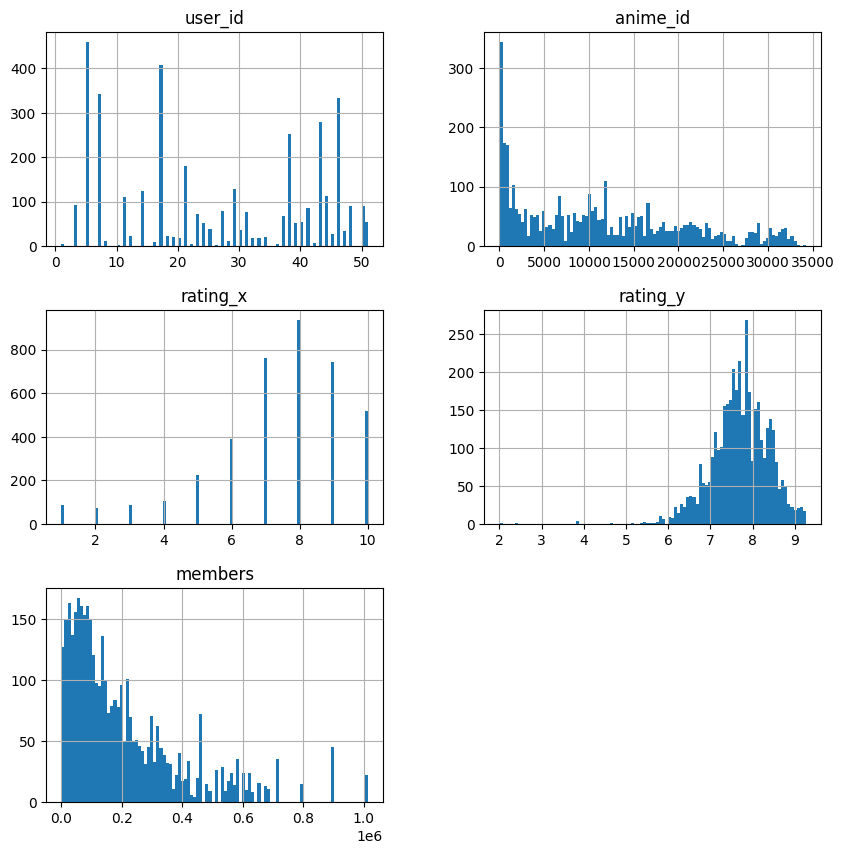

In [18]:
df.hist(figsize=[10, 10], bins=100)

<Axes: xlabel='user_id', ylabel='rating_x'>

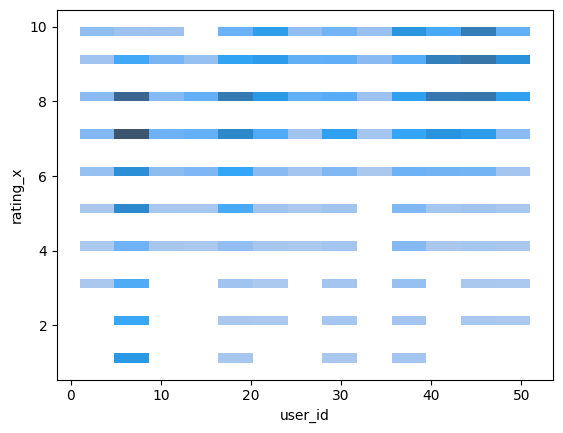

In [19]:
sns.histplot(data=df, x='user_id', y='rating_x')

## 3. Calculate the top-10 recommendations for each user

In [20]:
#construct reader
reader = Reader(rating_scale=(1, 10))
#generate surprise dataset
data = Dataset.load_from_df(df[['user_id', 'name', 'rating_x']], reader)

In [22]:
#set all data as training set
trainset = data.build_full_trainset()

#build and train an algorithm. Similar options

sim_options = {
               'user_based': True  # compute  similarities between items
}

algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [23]:
#predict ratings for all pairs (u, i) that are NOT in the training set
testset = trainset.build_anti_testset()
predictions = algo.test(testset)


In [24]:
# Check Surprise documentation at
# http://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 ['Hayate no Gotoku! Can&#039;t Take My Eyes Off You', 'Hayate no Gotoku! Cuties', 'Rose of Versailles', 'Kurenai no Buta', 'Shoujo Kakumei Utena', 'Muumindani no Suisei', 'Monster', 'Ping Pong The Animation', 'Cowboy Bebop', 'Karigurashi no Arrietty']
2 ['Dragon Ball Z Movie 10: Kiken na Futari! Super Senshi wa Nemurenai', 'Dragon Ball Z Movie 12: Fukkatsu no Fusion!! Gokuu to Vegeta', 'Detroit Metal City', 'Arakawa Under the Bridge', 'Arakawa Under the Bridge x Bridge', 'Inu x Boku SS', 'Hagure Yuusha no Aesthetica', 'Saint☆Oniisan', 'Noragami OVA', 'Hunter x Hunter (2011)']
3 ['Hayate no Gotoku! Can&#039;t Take My Eyes Off You', 'Hayate no Gotoku! Cuties', 'Rose of Versailles', 'Kurenai no Buta', 'Muumindani no Suisei', 'Ping Pong The Animation', 'Final Fantasy VII: Advent Children Complete', 'Aku no Hana', 'Mobile Fighter G Gundam', 'Seihou Bukyou Outlaw Star']
5 ['Hayate no Gotoku! Can&#039;t Take My Eyes Off You', 'Hayate no Gotoku! Cuties', 'Rose of Versailles', 'Kurenai no But

In [25]:
# Evaluate accuracy
# MAE = mean absolute error, RMSE = root mean squared error
cross_validate(algo, data, measures=['MAE', 'RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     1.5028  1.4963  1.5714  1.5771  1.5799  1.5455  0.0377  
RMSE (testset)    2.0724  2.0214  2.1522  2.1849  2.1803  2.1222  0.0646  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.01    0.01    0.00    0.01    0.01    0.00    


{'test_mae': array([1.50277943, 1.49631337, 1.57138038, 1.57712986, 1.57990785]),
 'test_rmse': array([2.07244896, 2.0213787 , 2.15217148, 2.18490344, 2.18032421]),
 'fit_time': (0.000997781753540039,
  0.000997781753540039,
  0.0009975433349609375,
  0.0,
  0.0009961128234863281),
 'test_time': (0.00498652458190918,
  0.005983114242553711,
  0.006011009216308594,
  0.004990100860595703,
  0.005983591079711914)}